# introduction to the vectorizing principle

## part 7: aggregation functions

The core of the vectorizing principle is treating rows separately. In this part, we look on 
aggregation functions which group the data and perform vectorized operations on each group.

#### the following code shows an aggregation function call in different libraries:


In [1]:
import pandas as pd
import polars as pl
import sqlalchemy as sa
import ibis
from ibis import _ as col
import pydiverse.transform as pdt
from pydiverse.pipedag import Flow, Stage, Table, materialize
from pydiverse.transform import λ
from pydiverse.transform.core.verbs import (
    mutate, alias, group_by, summarise, arrange, build_query,
)
from pydiverse.transform.eager import PandasTableImpl
from pydiverse.transform.lazy import SQLTableImpl


@materialize(input_type=pd.DataFrame, version="1.0.0")
def task_pandas(titanic: pd.DataFrame):
    return (
        titanic
        .assign(age_bucket=(titanic.age + 4.999).round(-1))
        .groupby("age_bucket")
        .agg(samples=("age_bucket", "count"), survival_likelyhood=("survived", "mean"))
        .sort_values("age_bucket")
    )


@materialize(input_type=pl.DataFrame, version="1.0.0")
def task_polars(titanic: pl.DataFrame):
    return (
        titanic
        .with_columns(age_bucket=(((pl.col("age") + 4.999) / 10).round() * 10))
        .groupby("age_bucket")
        .agg(samples=pl.col("age_bucket").count(),
             survival_likelyhood=pl.col("survived").mean())
        .sort("age_bucket")
    )


@materialize(input_type=PandasTableImpl, version="1.0.0")
def task_transform_df(titanic: pdt.Table):
    return (
        titanic
        >> mutate(age_bucket = round(λ.age + 4.999, -1))
        >> group_by(λ.age_bucket)
        >> summarise(samples=λ.age_bucket.count(),
                    survival_likelyhood=λ.survived.mean())
        >> arrange(λ.age_bucket)
        >> alias("transform_df")
    )


@materialize(input_type=SQLTableImpl, lazy=True)
def task_transform_sql(titanic: pdt.Table):
    return (
        titanic
        >> mutate(age_bucket = round(λ.age + 4.999, -1))
        >> group_by(λ.age_bucket)
        >> summarise(samples=λ.age_bucket.count(),
                    survival_likelyhood=λ.survived.mean())
        >> arrange(λ.age_bucket)
        >> alias("transform_sql")
    )


@materialize(input_type=ibis.api.Table, lazy=True)
def task_ibis(titanic: ibis.api.Table):
    return (
        titanic
        .mutate(age_bucket = (col.age + ibis.literal(4.999, "decimal")).round(-1))
        .group_by(col.age_bucket)
        .aggregate(samples=col.age_bucket.count(), survival_likelyhood=col.survived.mean())
        .order_by(col.age_bucket)
    )


@materialize(input_type=sa.Table, lazy=True)
def task_sqlalchemy(titanic: sa.Table):
    age_bucket = sa.func.round(titanic.c.age + 4.999, -1).label("age_bucket")
    return sa.select(
        age_bucket,
        sa.func.count(age_bucket).label("samples"),
        sa.func.avg(titanic.c.survived).label("survival_likelyhood")
    ).select_from(titanic).group_by(age_bucket).order_by(age_bucket)


@materialize(input_type=sa.Table, lazy=True)
def task_sql(titanic: sa.Table):
    return sa.text(f"""
        SELECT round((titanic.age + 4.999) / CAST(10 AS NUMERIC)) * 10        AS age_bucket,
               count(round((titanic.age + 4.999) / CAST(10 AS NUMERIC)) * 10) AS samples,
               AVG(titanic.survived)                                          AS survival_likelyhood
        FROM {titanic.original.schema}.{titanic.name} AS titanic
        GROUP BY round((titanic.age + 4.999) / CAST(10 AS NUMERIC)) * 10
        ORDER BY round((titanic.age + 4.999) / CAST(10 AS NUMERIC)) * 10 ASC NULLS LAST
    """)

#### define remaining tasks and helper functions

In [2]:
@materialize(version="1.0.0")
def read_input_data():
    titanic = pd.read_csv(
        'https://raw.githubusercontent.com/mwaskom/seaborn-data/master/titanic.csv'
    )
    return Table(titanic, name="titanic")


@materialize(input_type=pd.DataFrame, version="1.0.0")
def print_tables(tbls: list[pd.DataFrame]):
    for tbl in tbls:
        print(f"\n\n{tbl}")


def get_pipeline():
    tasks = [task_pandas, task_polars, task_transform_df, task_transform_sql,
             task_ibis, task_sqlalchemy, task_sql]
    with Flow("flow") as flow:
        with Stage("t1_raw_input"):
            titanic = read_input_data()

        with Stage("t2_transformed_data"):
            out_tbls = [task(titanic) for task in tasks]
            print_tables(out_tbls)

    return flow

#### define pipeline:

In [3]:
def get_pipeline():
    tasks = [task_pandas, task_polars, task_transform_df, task_transform_sql,
             task_ibis, task_sqlalchemy, task_sql]
    with Flow("flow") as flow:
        with Stage("t1_raw_input"):
            titanic = read_input_data()

        with Stage("t2_transformed_data"):
            out_tbls = [task(titanic) for task in tasks]
            print_tables(out_tbls)

    return flow

#### setup logging:

In [4]:
import logging
from pydiverse.pipedag.util.structlog import setup_logging
setup_logging(log_level=logging.INFO)

#### run pipeline:

2024-08-06 09:27:24.933038 [info     ] Initialized SQL Table Store    [DuckDBTableStore] engine_url=duckdb:////tmp/pipedag/vectorization/db.duckdb schema_prefix= schema_suffix=
2024-08-06 09:27:24.939821 [info     ] Initialized SQL Table Store    [DuckDBTableStore] engine_url=duckdb:////tmp/pipedag/vectorization/db.duckdb schema_prefix= schema_suffix=
2024-08-06 09:27:24.940331 [info     ] Starting IPCServer             [RunContextServer] address=tcp://127.0.0.1:64845
2024-08-06 09:27:24.955160 [info     ] Executing sql                  [DuckDBTableStore]
    [query]
    CREATE SCHEMA IF NOT EXISTS pipedag_metadata
2024-08-06 09:27:24.959829 [info     ] Executing sql                  [DuckDBTableStore]
    [query]
    CREATE SCHEMA IF NOT EXISTS t1_raw_input
2024-08-06 09:27:24.960592 [info     ] Executing sql                  [DuckDBTableStore]
    [query]
    DROP SCHEMA IF EXISTS t1_raw_input__even CASCADE
2024-08-06 09:27:24.961364 [info     ] Executing sql                  [DuckDB

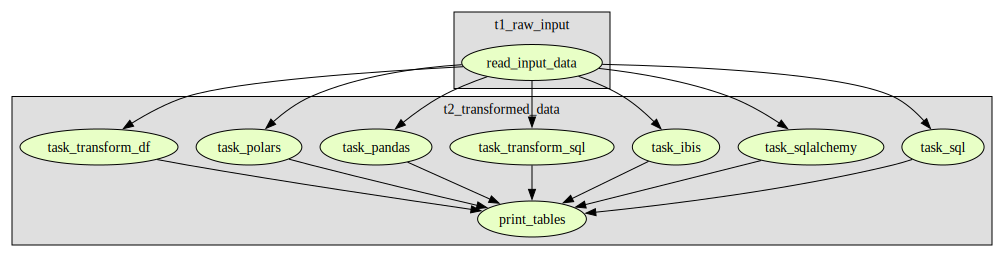

In [5]:
flow = get_pipeline()
result = flow.run()
result.visualize()
assert result.successful

Next: [vectorization08.ipynb](vectorization08.ipynb): window functions